In [1]:
import torch
import h5py
import matplotlib.pyplot as plt

import common
from core import *

In [2]:
data = h5py.File("data/out_poisson/poisson.h5")

geometry = torch.tensor(data["/Mesh/mesh/geometry"][...], dtype=torch.float32)
topology = torch.tensor(data["/Mesh/mesh/topology"][...], dtype=torch.int32)
func = torch.tensor(data["/Function/f/0"][...], dtype=torch.float32)

print(geometry.shape)
print(topology.shape)
print(func.shape)

torch.Size([81, 2])
torch.Size([128, 3])
torch.Size([81, 1])


In [3]:
def on_boundary(x):
    n = x.shape[0]
    return torch.isclose(x[:, 0], 0.0*torch.ones(n)) | \
           torch.isclose(x[:, 0], 1.0*torch.ones(n)) | \
           torch.isclose(x[:, 1], 0.0*torch.ones(n)) | \
           torch.isclose(x[:, 1], 1.0*torch.ones(n))

In [4]:
# get edges from topology
senders, receivers = common.topology_to_edges(topology) # two way connectivity implied
senders = senders.long()
receivers = receivers.long()

# compute mesh distances
senders_pos = geometry[senders]
receivers_pos = geometry[receivers]
mesh_distances = torch.sqrt((senders_pos[:, 0] - receivers_pos[:, 0])**2 + (senders_pos[:, 1] - receivers_pos[:, 1])**2)

# create edge set
edgeset = EdgeSet(senders.to(device), receivers.to(device), mesh_distances.to(device).view(-1, 1))

# create node features
node_types = F.one_hot(on_boundary(geometry).long())
node_features = torch.cat([node_types, func], dim=1)

# create graph
graph = MultiGraph(node_features.to(device), edgeset)

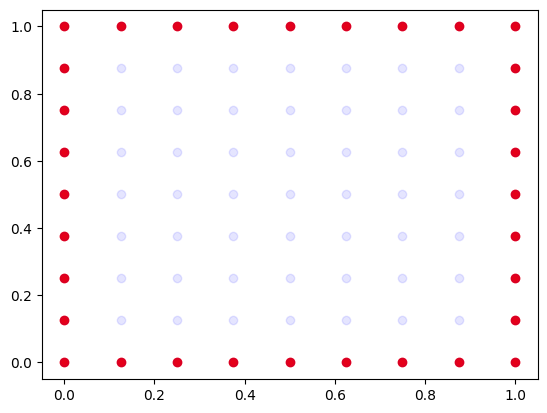

In [5]:
# visualise nodes with their types
x_b, y_b = torch.unbind(geometry[on_boundary(geometry)], dim=1)
x, y = torch.unbind(geometry, dim=1)
plt.scatter(x_b, y_b, c='r')
plt.scatter(x, y, c='b', alpha=0.1)
plt.show()

In [6]:
# display solution
import pyvista

def display_solution(scalar, name):

    n_cells = topology.shape[0]
    n_points = geometry.shape[0]

    cells_vtk = torch.cat([3*torch.ones(n_cells)[:, None], topology], dim=1).int().flatten().numpy()
    celltypes = [pyvista.CellType.TRIANGLE] * n_cells
    points = torch.cat([geometry, torch.zeros(n_points)[:, None]], dim=1).numpy()

    grid = pyvista.UnstructuredGrid(cells_vtk, celltypes, points)
    grid.point_data["u"] = scalar.numpy()
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=False)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    plotter.screenshot("solution/"+name)

display_solution(func, name="initial.png")

# Training loop

In [7]:
# let's try to do nothing at first
def train(model, epochs):
    loss_history = []

    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    
    for epoch in range(epochs):
        graph_init = graph

        node_features_exact = graph.node_features[:, -1]  # get only scalar node_features (without one-hot enc)
        node_features_pred = model.forward(graph_init).flatten()

        loss = loss_func(node_features_pred, node_features_exact)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"epoch: {epoch+1}, loss: {loss.item()}")
        loss_history.append(loss.item())
    
    return loss_history

In [8]:
# define graphnet model
model = GraphNet(message_passing_steps=15)

In [10]:
# train graphnet model
loss_history = train(model, epochs=100)

epoch: 1, loss: 0.010588083416223526
epoch: 2, loss: 0.03753188997507095
epoch: 3, loss: 0.0025887221563607454
epoch: 4, loss: 0.007213647942990065
epoch: 5, loss: 0.003442558227106929
epoch: 6, loss: 0.0026635508984327316
epoch: 7, loss: 0.0023171985521912575
epoch: 8, loss: 0.001480810227803886
epoch: 9, loss: 0.001956361113116145
epoch: 10, loss: 0.0012019320856779814
epoch: 11, loss: 0.0012563929194584489
epoch: 12, loss: 0.0010161325335502625
epoch: 13, loss: 0.0010183529229834676
epoch: 14, loss: 0.001064639538526535
epoch: 15, loss: 0.0008759544580243528
epoch: 16, loss: 0.001015694928355515
epoch: 17, loss: 0.0009033054811879992
epoch: 18, loss: 0.0008962741121649742
epoch: 19, loss: 0.0009958514710888267
epoch: 20, loss: 0.0008419567020609975
epoch: 21, loss: 0.0009094983688555658
epoch: 22, loss: 0.0008968192269094288
epoch: 23, loss: 0.0008298082393594086
epoch: 24, loss: 0.0008916661608964205
epoch: 25, loss: 0.0008092972566373646
epoch: 26, loss: 0.0008562938310205936
epoc

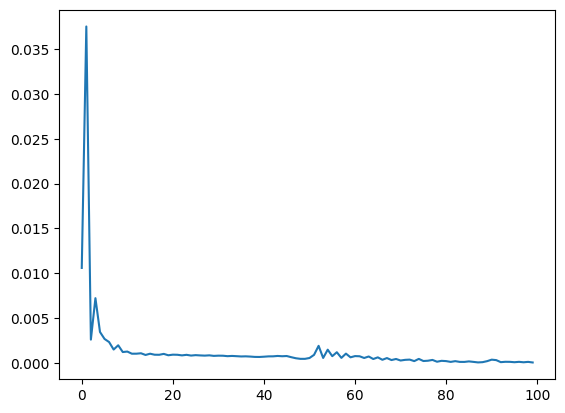

In [11]:
plt.plot(loss_history)

In [18]:
with torch.no_grad():
    scalar_pred = model.forward(graph).cpu()
display_solution(scalar_pred, name="solution.png")